In [38]:
source = 'DMRG' #'ED' or 'DMRG'
corrsType='raw' # 'raw' or 'normalised'

In [39]:
import time

print("Importing libraries...",end='')
t0 = time.time()

import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh
from scipy.linalg import ishermitian
from numpy import sqrt,exp,pi,zeros,arange,copy, sin, pi,loadtxt,poly1d, ones,reshape,floor,linspace

from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy


xs = linspace(-0.5,0.49999,101)
print("DONE in %0.3f [ms]"%(1000*(time.time()-t0)))

Importing libraries...DONE in 0.265 [ms]


In [50]:
def fg(j,n,x,Ns):
    if n==0:
        return 1/sqrt(1/Ns)
    if n==1:
        return sqrt(3*Ns)*(2*x*Ns-2*j-1)
    if n==2:
        return sqrt(5/4*Ns)*(3*(2*x*Ns-2*j-1)**2-1)
    print("ErrG")
    return 0

def G1(x,xp,Ns,Nn,Corrs1):
    j = floor(x*Ns)
    jp = floor(xp*Ns)
    
    out = 0
    for n in range(Nn):
        for np in range(Nn):
            out += fg(j,n,x,Ns)*fg(jp,np,xp,Ns)*Corrs1[j,n,jp,np]
    return out

def G2(x,xp,Ns,Nn,Corrs2):
    j = floor(x*Ns)
    jp = floor(xp*Ns)
    
    out = 0
    for n in range(Nn):
        for np in range(Nn):
            for npp in range(Nn):
                for nppp in range(Nn):
                    out += fg(j,n,x,Ns)*fg(jp,np,xp,Ns)*fg(jp,npp,xp,Ns)*fg(j,nppp,x,Ns)*Corrs2[j,jp,n,np,npp,nppp]
    return out


def getG2cutDMRG(xs,Ns,g,gdd,sigma):
    Corrs1 = {}
    if gdd == 'none':
        data = loadtxt('./Corrs1/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.2f_g%s_maxRange%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,maxRange,source))
    else:
        data = loadtxt('./Corrs1/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%.6f_gdd%.6f_sigma%.6f_maxRange%i_maxOcc%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,gdd,sigma,maxRange,2,source))

    for row in data:
        Corrs1[tuple([int(x) for x in row[0:-1]])] = float(row[-1])
        
    
    Corrs2 = {}
    if gdd == 'none':
        data = loadtxt('./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.6f_omega%.2f_g%.2f_maxRange%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,maxRange,source))
    else:
        data = loadtxt('./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%.6f_gdd%.6f_sigma%.6f_maxRange%i_maxOcc2_%s'%(N,Ns,Nn,PBC,Λ,ω,g,gdd,sigma,maxRange,source))

    for row in data:
        Corrs2[tuple([int(x) for x in row[0:-1]])] = float(row[-1])
    
    G1s = zeros((len(xs),len(xs)),dtype=float)
    G2s = zeros(len(xs),dtype=float)
    g2s = ones(len(xs),dtype=float)


    for ixp in range(len(xs)):
        G1s[ixp,ixp] = G1(xs[ixp],xs[ixp],Ns,Nn,Corrs1)
        G2s[ixp] = G2(xs[int(len(xs)/2)],xs[ixp],Ns,Nn,Corrs2)
        
    
    for ixp in range(len(xs)):     
       # print(xs[int(len(xs)/2)],xs[int(len(xs)/2)])
        if (G1s[int(len(xs)/2),int(len(xs)/2)]>1e-4) and (G1s[ixp,ixp]>1e-4):
            g2s[ixp] = 4*G2s[ixp]/G1s[int(len(xs)/2),int(len(xs)/2)]/G1s[ixp,ixp]
        else:
            g2s[ixp] = np.nan

    return G2s, [G1s[i,i] for i in range(len(xs))]



def getEnergyDMRG(Ns,g,gdd,sigma):
    if gdd == 'none':
        data = loadtxt('./Energies/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.2f_g%.2f_maxRange%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,maxRange,source),usecols=(1))
    else:
        data = loadtxt('./Energies/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%.6f_gdd%.6f_sigma%.6f_maxRange%i_maxOcc2_%s'%(N,Ns,Nn,PBC,Λ,ω,g,gdd,sigma,maxRange,source),usecols=(1))
    return data[-1]-data[-2]

def getEnergyRef(N,g,gdd,sigma,pMax,m):
    data = loadtxt('./program_wojtka-main/data/energies_n%i_pmax%i_ptot0_neig1_m%i_g%.6f_gdd%.6f_sigma%.6f.txt'%(N,pMax,m,g,abs(gdd),sigma))
    return data[0]

def getG2cutRef(N,Ns,g,gdd,sigma,pMax,m):
    pTot=0
    nEig=1
    dataW = np.loadtxt("./program_wojtka-main/data/cov_n%i_pmax%i_ptot%i_neig%i_m%i_g%.6f_gdd%.6f_sigma%.6f.txt"%(N,pMax,pTot,nEig,m,float(g),abs(float(gdd)),sigma))
    return dataW[:,1]

def getXscutRef(N,Ns,g,gdd,sigma,pMax,m):
    pTot=0
    nEig=1
    dataW = np.loadtxt("./program_wojtka-main/data/cov_n%i_pmax%i_ptot%i_neig%i_m%i_g%.6f_gdd%.6f_sigma%.6f.txt"%(N,pMax,pTot,nEig,m,float(g),abs(float(gdd)),sigma))
    return dataW[:,0]

FileNotFoundError: ./Corrs1/N2_Ns40_Nn3_PBC0_Lambda1000.00_omega0.000000_g1.000000_gdd-0.500000_sigma0.025000_maxRange8_maxOcc2_DMRG not found.

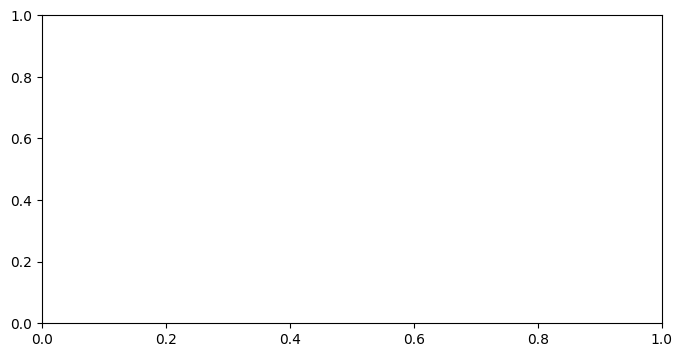

In [60]:
N,Ns,Nn = 2,40,3
PBC,Λ,maxRange = 0,1000,8
ω,g,σ = 0.0,1.0,1/Ns
fig, ax = plt.subplots(1,1,figsize=[8,4])

j=0
for gdd in [-0.5]:
    PBC=0
    g2s,density = getG2cutDMRG(xs,Ns,g,gdd,σ)
   # ax.plot(xs,g2s,label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
    ax.plot(xs,[g2s[i]/density[i] for i in range(len(xs))],label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
   # ax.plot(xs,density,label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
    PBC=1
    maxRange=4
    g2s,density = getG2cutDMRG(xs,Ns,g,gdd,σ)
    ax.plot(xs,g2s,label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
   # ax.plot(xs,density,label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
    ax.plot(getXscutRef(N,Ns,g,gdd,σ,250,450),getG2cutRef(N,Ns,g,gdd,σ,250,450),'--',label='Ref,     E=%.4f'%(getEnergyRef(N,g,gdd,σ,250,450)))
    
    ax.set_xlabel('x')
    ax.grid()
  #  ax[j].text(-0.48,1.8,r'$g_{dd}$=%.2f'%(gdd),fontsize=16)
    #ax[j].set_ylim([1.65,2.2])
    ax.legend( )
    j+=1

ax.set_ylabel(r'$G_2(0,x)$')
fig.suptitle('N=%i, $N_s$=%i, $N_n$=%i, PBC=%i, $\Lambda$=%i, $\omega$=%.6f, $g$=%.6f, $\sigma$=%.6f, maxRange=%i'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange))

plt.savefig('./figures/Compare_DMRG_N%i_$N_s$%i_$N_n$%i_PBC%i_$\Lambda$%i_$\omega$%.2f_$g$%.2f_$\sigma$%.3f_maxRange%i.png'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange),dpi=300)
plt.show()

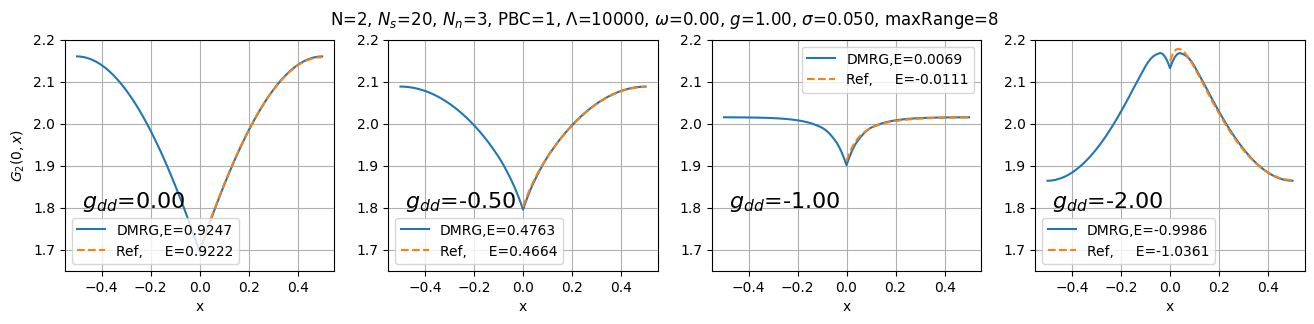

In [5]:
N,Ns,Nn = 2,20,3
PBC,Λ,maxRange = 1,10000,8
ω,g,σ = 0.0,1.0,1/Ns
fig, ax = plt.subplots(1,4,figsize=[16,3])

j=0
for gdd in [0.0,-0.5,-1.0,-2.0]:
    ax[j].plot(xs,getG2cutDMRG(xs,Ns,g,gdd,σ),label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
    ax[j].plot(getXscutRef(N,Ns,g,gdd,σ,250,450),getG2cutRef(N,Ns,g,gdd,σ,250,450),'--',label='Ref,     E=%.4f'%(getEnergyRef(N,g,gdd,σ,250,450)))
    
    ax[j].set_xlabel('x')
    ax[j].grid()
    ax[j].text(-0.48,1.8,r'$g_{dd}$=%.2f'%(gdd),fontsize=16)
    ax[j].set_ylim([1.65,2.2])
    ax[j].legend( )
    j+=1

ax[0].set_ylabel(r'$G_2(0,x)$')
fig.suptitle('N=%i, $N_s$=%i, $N_n$=%i, PBC=%i, $\Lambda$=%i, $\omega$=%.2f, $g$=%.2f, $\sigma$=%.3f, maxRange=%i'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange))

plt.savefig('./figures/Compare_DMRG_N%i_$N_s$%i_$N_n$%i_PBC%i_$\Lambda$%i_$\omega$%.2f_$g$%.2f_$\sigma$%.3f_maxRange%i.png'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange),dpi=300)
plt.show()

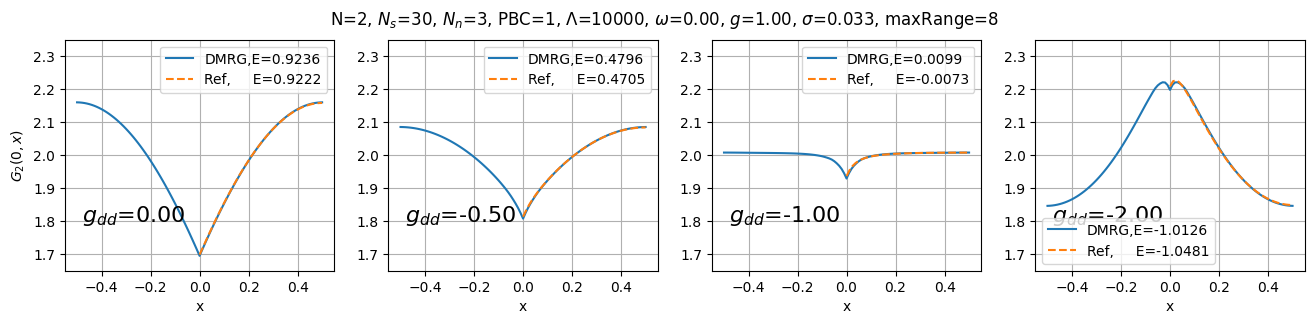

In [6]:
N,Ns,Nn = 2,30,3
PBC,Λ,maxRange = 1,10000,8
ω,g,σ = 0.0,1.0,0.033
fig, ax = plt.subplots(1,4,figsize=[16,3])

j=0
for gdd in [0.0,-0.5,-1.0,-2.0]:
    ax[j].plot(xs,getG2cutDMRG(xs,Ns,g,gdd,σ),label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
    ax[j].plot(getXscutRef(N,Ns,g,gdd,σ,250,450),getG2cutRef(N,Ns,g,gdd,σ,250,450),'--',label='Ref,     E=%.4f'%(getEnergyRef(N,g,gdd,σ,250,450)))
    
    ax[j].set_xlabel('x')
    ax[j].grid()
    ax[j].text(-0.48,1.8,r'$g_{dd}$=%.2f'%(gdd),fontsize=16)
    ax[j].set_ylim([1.65,2.35])
    ax[j].legend( )
    j+=1

ax[0].set_ylabel(r'$G_2(0,x)$')
fig.suptitle('N=%i, $N_s$=%i, $N_n$=%i, PBC=%i, $\Lambda$=%i, $\omega$=%.2f, $g$=%.2f, $\sigma$=%.3f, maxRange=%i'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange))

plt.savefig('./figures/Compare_DMRG_N%i_$N_s$%i_$N_n$%i_PBC%i_$\Lambda$%i_$\omega$%.2f_$g$%.2f_$\sigma$%.3f_maxRange%i.png'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange),dpi=300)
plt.show()

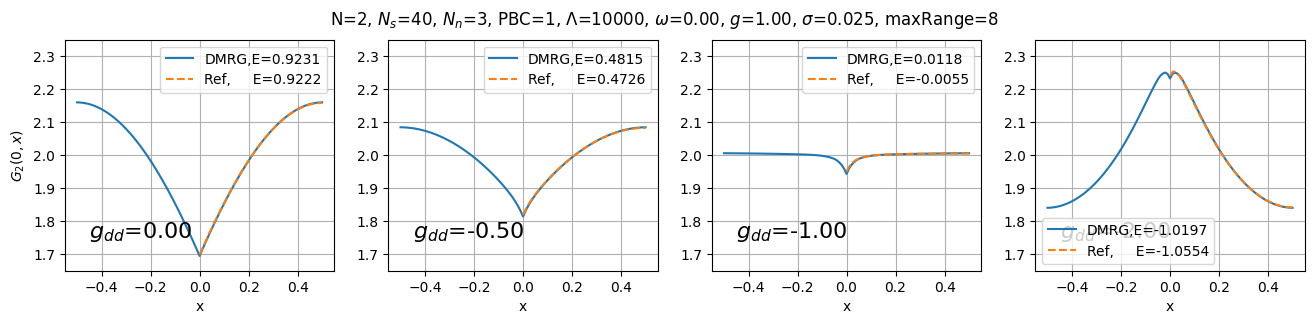

In [7]:
N,Ns,Nn = 2,40,3
PBC,Λ,maxRange = 1,10000,8
ω,g,σ = 0.0,1.0,0.025
fig, ax = plt.subplots(1,4,figsize=[16,3])

j=0
for gdd in [0.0,-0.5,-1.0,-2.0]:
    ax[j].plot(xs,getG2cutDMRG(xs,Ns,g,gdd,σ),label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
    ax[j].plot(getXscutRef(N,Ns,g,gdd,σ,250,450),getG2cutRef(N,Ns,g,gdd,σ,250,450),'--',label='Ref,     E=%.4f'%(getEnergyRef(N,g,gdd,σ,250,450)))
    
    ax[j].set_xlabel('x')
    ax[j].grid()
    ax[j].text(-0.45,1.75,r'$g_{dd}$=%.2f'%(gdd),fontsize=16)
    ax[j].set_ylim([1.65,2.35])
    ax[j].legend()
    j+=1

ax[0].set_ylabel(r'$G_2(0,x)$')
fig.suptitle('N=%i, $N_s$=%i, $N_n$=%i, PBC=%i, $\Lambda$=%i, $\omega$=%.2f, $g$=%.2f, $\sigma$=%.3f, maxRange=%i'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange))

plt.savefig('./figures/Compare_DMRG_N%i_$N_s$%i_$N_n$%i_PBC%i_$\Lambda$%i_$\omega$%.2f_$g$%.2f_$\sigma$%.3f_maxRange%i.png'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange),dpi=300)
plt.show()  

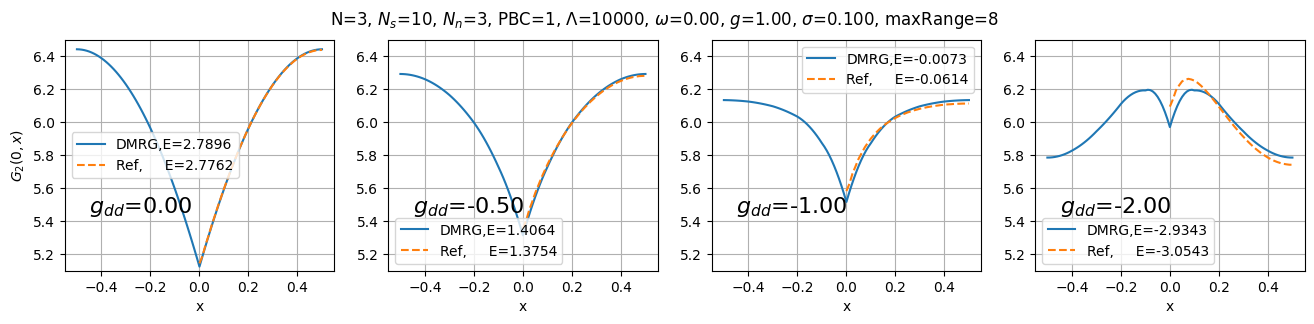

In [8]:
N,Ns,Nn = 3,10,3
PBC,Λ,maxRange = 1,10000,8
ω,g,σ = 0.0,1.0,0.1
fig, ax = plt.subplots(1,4,figsize=[16,3])

j=0
for gdd in [0.0,-0.5,-1.0,-2.0]:
    ax[j].plot(xs,getG2cutDMRG(xs,Ns,g,gdd,σ),label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
    ax[j].plot(getXscutRef(N,Ns,g,gdd,σ,50,250),getG2cutRef(N,Ns,g,gdd,σ,50,250),'--',label='Ref,     E=%.4f'%(getEnergyRef(N,g,gdd,σ,50,250)))
    
    ax[j].set_xlabel('x')
    ax[j].grid()
    ax[j].text(-0.45,5.45,r'$g_{dd}$=%.2f'%(gdd),fontsize=16)
    ax[j].set_ylim([5.1,6.5])
    ax[j].legend( )
    j+=1

ax[0].set_ylabel(r'$G_2(0,x)$')
fig.suptitle('N=%i, $N_s$=%i, $N_n$=%i, PBC=%i, $\Lambda$=%i, $\omega$=%.2f, $g$=%.2f, $\sigma$=%.3f, maxRange=%i'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange))

plt.savefig('./figures/Compare_DMRG_N%i_$N_s$%i_$N_n$%i_PBC%i_$\Lambda$%i_$\omega$%.2f_$g$%.2f_$\sigma$%.3f_maxRange%i.png'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange),dpi=300)
plt.show()  

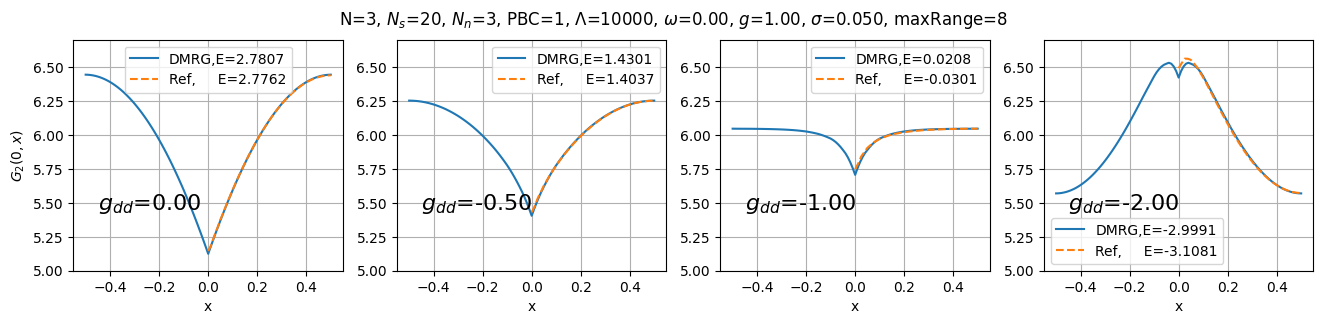

In [9]:
N,Ns,Nn = 3,20,3
PBC,Λ,maxRange = 1,10000,8
ω,g,σ = 0.0,1.0,0.05
fig, ax = plt.subplots(1,4,figsize=[16,3])

j=0
for gdd in [0.0,-0.5,-1.0,-2.0]:
    ax[j].plot(xs,getG2cutDMRG(xs,Ns,g,gdd,σ),label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
    ax[j].plot(getXscutRef(N,Ns,g,gdd,σ,50,250),getG2cutRef(N,Ns,g,gdd,σ,50,250),'--',label='Ref,     E=%.4f'%(getEnergyRef(N,g,gdd,σ,50,250)))
    
    ax[j].set_xlabel('x')
    ax[j].grid()
    ax[j].text(-0.45,5.45,r'$g_{dd}$=%.2f'%(gdd),fontsize=16)
    ax[j].set_ylim([5.0,6.7])
    ax[j].legend( )
    j+=1

ax[0].set_ylabel(r'$G_2(0,x)$')
fig.suptitle('N=%i, $N_s$=%i, $N_n$=%i, PBC=%i, $\Lambda$=%i, $\omega$=%.2f, $g$=%.2f, $\sigma$=%.3f, maxRange=%i'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange))

plt.savefig('./figures/Compare_DMRG_N%i_$N_s$%i_$N_n$%i_PBC%i_$\Lambda$%i_$\omega$%.2f_$g$%.2f_$\sigma$%.3f_maxRange%i.png'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange),dpi=300)
plt.show()  

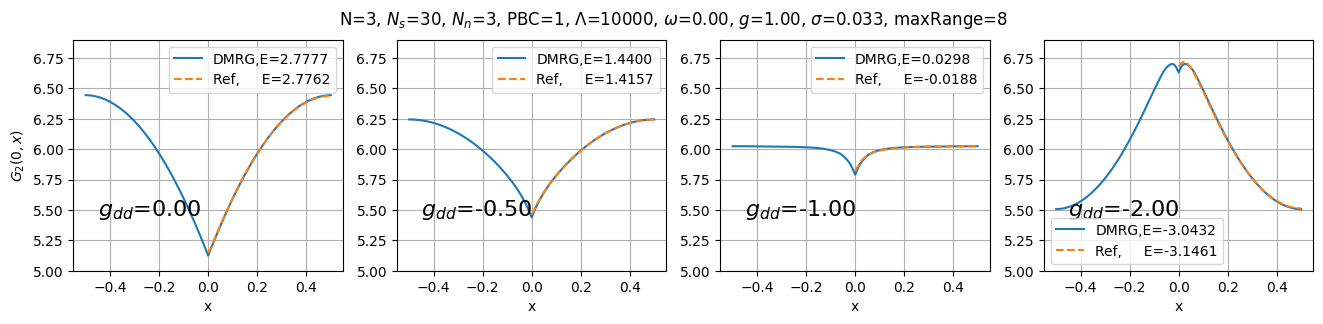

In [12]:
N,Ns,Nn = 3,30,3
PBC,Λ,maxRange = 1,10000,8
ω,g,σ = 0.0,1.0,0.033
fig, ax = plt.subplots(1,4,figsize=[16,3])

j=0
for gdd in [0.0,-0.5,-1.0,-2.0]:
    ax[j].plot(xs,getG2cutDMRG(xs,Ns,g,gdd,σ),label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
    ax[j].plot(getXscutRef(N,Ns,g,gdd,σ,50,250),getG2cutRef(N,Ns,g,gdd,σ,50,250),'--',label='Ref,     E=%.4f'%(getEnergyRef(N,g,gdd,σ,50,250)))
    
    ax[j].set_xlabel('x')
    ax[j].grid()
    ax[j].text(-0.45,5.45,r'$g_{dd}$=%.2f'%(gdd),fontsize=16)
    ax[j].set_ylim([5.0,6.9])
    ax[j].legend( )
    j+=1

ax[0].set_ylabel(r'$G_2(0,x)$')
fig.suptitle('N=%i, $N_s$=%i, $N_n$=%i, PBC=%i, $\Lambda$=%i, $\omega$=%.2f, $g$=%.2f, $\sigma$=%.3f, maxRange=%i'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange))

plt.savefig('./figures/Compare_DMRG_N%i_$N_s$%i_$N_n$%i_PBC%i_$\Lambda$%i_$\omega$%.2f_$g$%.2f_$\sigma$%.3f_maxRange%i.png'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange),dpi=300)
plt.show()  

FileNotFoundError: ./program_wojtka-main/data/cov_n3_pmax50_ptot0_neig1_m250_g1.000000_gdd0.000000_sigma0.025000.txt not found.

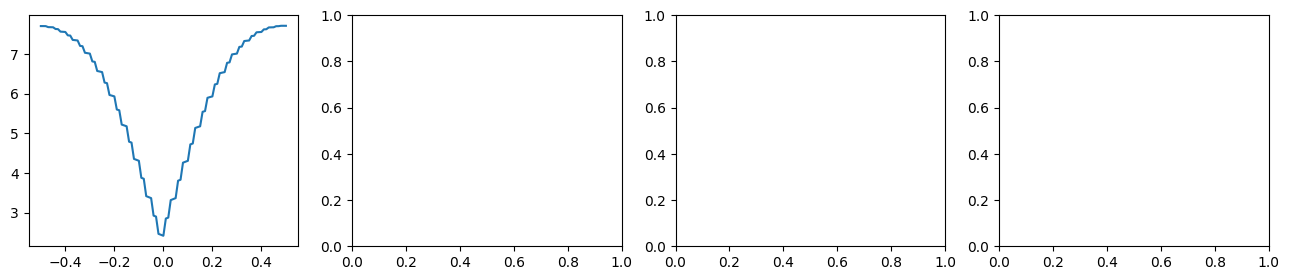

In [13]:
N,Ns,Nn = 3,40,3
PBC,Λ,maxRange = 1,3,8
ω,g,σ = 0.0,1.0,0.025
fig, ax = plt.subplots(1,4,figsize=[16,3])

j=0
for gdd in [0.0,-0.5,-1.0,-2.0]:
    ax[j].plot(xs,getG2cutDMRG(xs,Ns,g,gdd,σ),label='DMRG,E=%.4f'%(getEnergyDMRG(Ns,g,gdd,σ)))
    ax[j].plot(getXscutRef(N,Ns,g,gdd,σ,50,250),getG2cutRef(N,Ns,g,gdd,σ,50,250),'--',label='Ref,     E=%.4f'%(getEnergyRef(N,g,gdd,σ,50,250)))
    
    ax[j].set_xlabel('x')
    ax[j].grid()
    ax[j].text(-0.45,5.45,r'$g_{dd}$=%.2f'%(gdd),fontsize=16)
    ax[j].set_ylim([5.0,6.9])
    ax[j].legend( )
    j+=1

ax[0].set_ylabel(r'$G_2(0,x)$')
fig.suptitle('N=%i, $N_s$=%i, $N_n$=%i, PBC=%i, $\Lambda$=%i, $\omega$=%.2f, $g$=%.2f, $\sigma$=%.3f, maxRange=%i'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange))

plt.savefig('./figures/Compare_DMRG_N%i_$N_s$%i_$N_n$%i_PBC%i_$\Lambda$%i_$\omega$%.2f_$g$%.2f_$\sigma$%.3f_maxRange%i.png'%(N,Ns,Nn,PBC,Λ,ω,g,σ,maxRange),dpi=300)
plt.show() 